In [5]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [6]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((X_train, y_train), (X_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

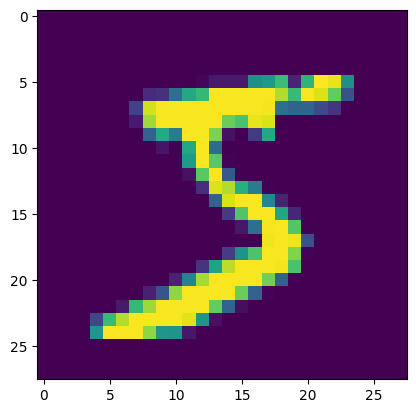

In [7]:
import matplotlib.pyplot as plt 
plt.imshow(X_train[0].reshape((28,28)))

In [8]:
# Create PyTorch tensors
import torch

X_train, y_train, X_valid, y_valid = map(torch.tensor, (X_train, y_train, X_valid, y_valid))
n, c = X_train.shape
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [9]:
import math

weights = torch.rand(784, 10)/math.sqrt(784)    # Xavier Initialization
weights.requires_grad_()    # Set requires_grad=True after initialization because we don't need the initializatio step in tracked ops
bias = torch.zeros(10, requires_grad=True)

In [10]:
def log_softmax(x):
    # print(x.shape)
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):  # Only output layer (Hence it will act like a Logistic Regression model)
    # print(xb.shape)
    return log_softmax(xb @ weights + bias)

In [11]:
bs = 64
xb = X_train[0:bs]  # first batch
print(xb.shape)
preds = model(xb)
preds.shape

torch.Size([64, 784])


torch.Size([64, 10])

In [12]:
# Loss function
def nll(input ,target):
    # print(input.shape, target.shape)
    return -input[range(target.shape[0]), target].mean()

loss_fn = nll

In [13]:
yb = y_train[0:bs]
print(loss_fn(preds, yb))

tensor(2.2758, grad_fn=<NegBackward0>)


In [14]:
from IPython.core.debugger import set_trace

lr = 0.5  
epochs = 20  

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = X_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [15]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [16]:
print(loss_fn(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0511, grad_fn=<NegBackward0>) tensor(1.)


## Refactor to se `torch.nn`

In [53]:
from torch import nn
import torch.nn.functional as F     # Contains all functions in torch.nn, the other part of the library includes classes

loss_fn = F.cross_entropy   # NLL(softmax(y_pred, y))

def model(xb):
    return xb @ weights + bias

xb = X_train[:bs]
yb = y_train[:bs]
print(loss_fn(model(xb), yb), accuracy(model(xb), yb))

tensor(0.1491, grad_fn=<NllLossBackward0>) tensor(0.9531)


In [ ]:
class Mnist_Logistic(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Manually define and initialize weights
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784)) # nn.Parameter() class handles mdoel parameters (like adding requires_grad=True etc), self.weights and self.bias here are now added to and treated as model parameters.
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb@self.weights + self.bias

model = Mnist_Logistic()

In [49]:
loss_fn(model(xb), yb)

tensor(2.4212, grad_fn=<NllLossBackward0>)

In [39]:
list(iter(model.parameters()))

[Parameter containing:
 tensor([[-0.0105, -0.0410,  0.0405,  ..., -0.0338, -0.0174, -0.0276],
         [-0.0326,  0.0371, -0.0313,  ...,  0.0493, -0.0006, -0.0243],
         [ 0.0190,  0.0482, -0.0197,  ..., -0.0167, -0.0438,  0.0636],
         ...,
         [-0.0050,  0.0293,  0.0014,  ...,  0.0241,  0.0101, -0.0363],
         [ 0.0404, -0.0326,  0.0012,  ..., -0.0589, -0.0173, -0.0254],
         [-0.0027,  0.0336,  0.0107,  ..., -0.0016,  0.0054, -0.0192]],
        requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)]

In [52]:
lr = 0.01
with torch.no_grad():
    for p in model.parameters():
        p -= p.grad*lr
    model.zero_grad()

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

The above error is because `grad` for at least one `p` is `None` somewhere. This is because there are no grads - we never called the `loss.backward()` and never computed them.

In [ ]:
# The final method
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs+1):
            start_i = i*bs
            end_i = start_i + bs
            xb = X_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            preds = model(xb)
            loss = loss_fn(preds, yb)

            loss.backward()

            # Manual implementation of `opt.step(); opt.zero_grad()`
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr        # Optimization algorithm manually 
                model.zero_grad()   # Otherwise grads would add up in the next loop

fit()

In [57]:
loss_fn(model(X_valid), y_valid)

tensor(0.3061, grad_fn=<NllLossBackward0>)

### Refactor with `torch.Linear`

In [58]:
# Linear(m, n) creates a layer with m*n weights and n biases and then calculates x@weights + bias
class Mnist_Logistic_Auto(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lin = nn.Linear(784, 10)   # Check about weight initialization later

    def forward(self, xb):
        return self.lin(xb)

model = Mnist_Logistic_Auto()
print(loss_fn(model(xb), yb))

tensor(2.3947, grad_fn=<NllLossBackward0>)


In [59]:
fit()
print(loss_fn(model(X_valid), y_valid))

tensor(0.3057, grad_fn=<NllLossBackward0>)


### Refactor with `torch.optim`

In [64]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_fn(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = X_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_fn(model(xb), yb))

tensor(2.2503, grad_fn=<NllLossBackward0>)
tensor(0.5625, grad_fn=<NllLossBackward0>)


### Refactor with `Dataset` and `DataLoader`

In [65]:
from torch.utils.data import TensorDataset
train_ds = TensorDataset(X_train, y_train)